In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 10 15:14:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    56W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from scipy.special import softmax
from scipy.stats import zscore

import matplotlib.pyplot as plt

In [ ]:
path = '/content/drive/MyDrive/tms'

# Preprocessing of the overall dataset with Multi binarizer
Preprop for base, base model

*input*: date / daypart / channel + first item

*output*: the rest of the items

### Date, Dayparts, Channel

In [ ]:
df = pd.read_csv('/'.join([path, 'transactions_casestudy.txt']), header = 'infer', sep='|', index_col=0)
df.index -= 1 # For less confusion in further analysis . . .

In [ ]:
df.head()

,date,daypart,channel,items
tid,,,,
0,2016-03-02,A,1,"21d683,21d683"
1,2016-03-02,A,1,"aa254f,524e24,2f4a70,6ca4a6,221380,b8bfe8,2213..."
2,2016-03-02,A,2,"fe5db1,aa254f,550e0e,7356a8,7356a8"
3,2016-03-02,A,2,4d51b8
4,2016-03-02,A,2,6050b0


In [ ]:
# Date

df['Month'] = pd.to_datetime(df['date']).dt.strftime('%m')
df['Date'] = pd.to_datetime(df['date']).dt.strftime('%d')
df = df.drop('date', axis=1)

# Dayaprt
daypartset = df['daypart'].unique()
daypart_encoder = OneHotEncoder()
dp = pd.DataFrame(daypart_encoder.fit_transform(df[['daypart']]).toarray(), 
                  columns = daypart_encoder.get_feature_names_out(['daypart']))
df = df.join(dp)
df = df.drop('daypart', axis=1)

# Channel
channelset = df['channel'].unique()
channel_encoder = OneHotEncoder()
dc = pd.DataFrame(channel_encoder.fit_transform(df[['channel']]).toarray(),
                  columns = channel_encoder.get_feature_names_out(['channel']))
df = df.join(dc)
df = df.drop('channel', axis=1)
df.head()

,items,Month,Date,daypart_A,daypart_B,daypart_C,daypart_D,daypart_E,daypart_F,channel_1,channel_2,channel_3
tid,,,,,,,,,,,,
0,"21d683,21d683",03,02,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"aa254f,524e24,2f4a70,6ca4a6,221380,b8bfe8,2213...",03,02,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"fe5db1,aa254f,550e0e,7356a8,7356a8",03,02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4d51b8,03,02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6050b0,03,02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Data Augmentation

In [ ]:
# Split train and test before train data is augmented
X, X_unseen, y, y_unseen = train_test_split(df.drop('items', axis=1), df['items'], test_size=0.1, random_state=819)
print("Number of orders for training: ", len(X))
print("Number of orders for validation: ", len(X_unseen))

Number of orders for training:  37165
Number of orders for validation:  4130


In [ ]:
# Transform items into a list of labels
df1 = pd.concat([X, y], axis=1)
df1['first_item'] = df1['items'].apply(lambda x: str(x.split(',')[0]))
df1['items'] = df1['items'].apply(lambda x: str(x).split(','))
df1 = df1.reset_index().drop('tid', axis=1)

In [ ]:
# Data augmentation
import random 

df2 = df.copy()
lenvec = df2['items'].apply(lambda x: len(set(x.split(','))))

df_aug = df2[lenvec == 1]
df_aug['first_item'] = df_aug['items'].apply(lambda x: str(x.split(',')[0]))

for i in range(2, max(lenvec)): #n of unique items

  itemset = df2['items'][lenvec == i].apply(lambda x: list(set(x.split(','))))
  itemlist = [item for sublist in itemset for item in sublist]

  temp = df2.reindex(df2[lenvec == i].index.repeat(i))
  temp['first_item'] = itemlist

  # Drop out some augmented dataset
  temp = temp.iloc[random.sample(range(0, len(itemlist)), int(len(itemlist)*(3/4))),:]

  df_aug = temp.append(df_aug) 

df_aug['items'] = df_aug['items'].apply(lambda x: str(x).split(','))
df_aug = df_aug.sort_index()
df_aug = df_aug.reset_index().drop('tid', axis=1)

<ipython-input-12-435bf3caee0a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['first_item'] = df_aug['items'].apply(lambda x: str(x.split(',')[0]))


In [ ]:
i=3

itemset = df2['items'][lenvec == i].apply(lambda x: list(set(x.split(','))))
itemlist = [item for sublist in itemset for item in sublist]

temp = df2.reindex(df2[lenvec == i].index.repeat(i))
temp['first_item'] = itemlist
temp[['items', 'first_item']].head(7)

,items,first_item
tid,,
6,"6050b0,dc9f6a,321958",321958
6,"6050b0,dc9f6a,321958",6050b0
6,"6050b0,dc9f6a,321958",dc9f6a
15,"ea300a,ea300a,ea300a,62972e,33514b",ea300a
15,"ea300a,ea300a,ea300a,62972e,33514b",33514b
15,"ea300a,ea300a,ea300a,62972e,33514b",62972e
18,"7356a8,363929,316e9f",7356a8


In [ ]:
# Validation data
df_unseen = pd.concat([X_unseen, y_unseen], axis=1)
df_unseen['first_item'] = df_unseen['items'].apply(lambda x: str(x.split(',')[0]))
df_unseen['items'] = df_unseen['items'].apply(lambda x: str(x).split(','))

df_unseen = df_unseen.reset_index().drop('tid', axis=1)

In [ ]:
# # Model2: Learning with the all items
# # Transform items into a list of labels
# import random 
# df_all = pd.concat([X, y], axis=1)
# df_all['first_item'] = df_all['items'].apply(lambda x: str(x).split(','))
# df_all['first_item'] = df_all['first_item'].apply(lambda x: random.sample(x, int(len(x)/2)+1)) ## dropout

# df_all['items'] = df_all['items'].apply(lambda x: str(x).split(','))
# df_all = df_all.reset_index().drop('tid', axis=1)
# df_all.head()

### Fit the Item Encoder

In [ ]:
# Fit the multi-label binarizer on the training set
print("Labels:")
item_encoder = MultiLabelBinarizer()
item_encoder.fit(df1['items'])

# Loop over all labels and show them
N_LABELS = len(item_encoder.classes_)
for (i, label) in enumerate(item_encoder.classes_):
    print("{}. {}".format(i, label))

Labels:
0. 03bdf7
1. 086cbd
2. 0c816e
3. 11170d
4. 11c5cc
5. 15d7d5
6. 172d33
7. 192a28
8. 1bfcc7
9. 20b01a
10. 21d683
11. 221380
12. 230526
13. 23563a
14. 245903
15. 292491
16. 2b87d9
17. 2e8f53
18. 2f4a70
19. 2fa5df
20. 31299d
21. 316e9f
22. 321958
23. 3254e9
24. 330e2e
25. 33514b
26. 355770
27. 35c117
28. 363929
29. 368d36
30. 381682
31. 39777e
32. 3a9985
33. 3ef6c2
34. 487aef
35. 4c85c6
36. 4d51b8
37. 51238a
38. 524e24
39. 550e0e
40. 5545a4
41. 5c1bb1
42. 6050b0
43. 61e8c0
44. 62972e
45. 667497
46. 696343
47. 6ca4a6
48. 70aa12
49. 7356a8
50. 73e6b6
51. 7a0017
52. 8319aa
53. 86100a
54. 87050c
55. 8ec81d
56. 8fc9b1
57. 908b4b
58. 9237b2
59. 946878
60. 9587fa
61. 98bcbd
62. 995af2
63. 9d0327
64. 9fc08c
65. a2f610
66. a378da
67. a7d067
68. aa254f
69. ac2136
70. ae2aad
71. afe15d
72. b23f78
73. b31707
74. b34fdf
75. b472f3
76. b59cb7
77. b65c47
78. b6d9d1
79. b8bfe8
80. bd59c4
81. be94a7
82. bf0192
83. c2456b
84. c5f033
85. c86de4
86. c885ce
87. c8add4
88. cb06d4
89. cf13ba
90. d36e57
9

In [ ]:
df_train = df_aug

X = df_train.drop('items', axis=1)
y = df_train['items']

X_unseen = df_unseen.drop('items', axis=1)
y_unseen = df_unseen['items']

In [ ]:
def apply_item_encoder(X, y):

    item_cols = ['item_' + i for i in item_encoder.classes_]
    encoded_f_items = item_encoder.transform([i] for i in X['first_item'])

    new_df = pd.DataFrame(encoded_f_items, columns = item_cols)
    X = pd.concat([X, new_df], axis=1).drop('first_item', axis=1)

    encoded_rest_items = item_encoder.transform(i for i in y)
    encoded_rest_items = encoded_rest_items - encoded_f_items # This removes the first item from the list of the rest items 

    y = encoded_rest_items

    return X, y

In [ ]:
X, y = apply_item_encoder(X, y)
X_unseen, y_unseen = apply_item_encoder(X_unseen, y_unseen)

In [ ]:
# single order ratio
(y.sum(axis=1) > 0).sum(axis=0) / len(y.sum(axis=1) > 0)

0.8581392174139664

# 1. Recommendation with the first item (No update)

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
import time 
print(tf.__version__)

2.9.2


In [ ]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [ ]:
print("Number of orders for training: ", df1.shape[0])

Number of orders for training:  37165


In [ ]:
#X_train_tensor = tf.convert_to_tensor(X_notsingle, dtype = tf.float32)
#y_train_tensor = tf.convert_to_tensor(y_notsingle, dtype=tf.int64) 

X_train_tensor = tf.convert_to_tensor(X, dtype = tf.float32)
y_train_tensor = tf.convert_to_tensor(y, dtype=tf.int64) 

X_val_tensor = tf.convert_to_tensor(X_unseen, dtype = tf.float32)
y_val_tensor = tf.convert_to_tensor(y_unseen, dtype=tf.int64) 

print("Number of orders for training: ", len(X_train_tensor))
print("Number of orders for validation: ", len(X_val_tensor))

Number of orders for training:  80579
Number of orders for validation:  4130


In [ ]:
# Hit metric !
@tf.function

def hit_rates(y, y_hat):
    """Compute the hit ratio on a batch of observations 
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        hit_rates (scalar Tensor): rates of hit of the batch
    """
    
    max_pred = y_hat.numpy()
    zerovec = np.zeros(max_pred.shape)
    max_pred = max_pred.argsort()

    for z, top3_arg in zip(zerovec, max_pred):
      top3_arg = top3_arg[:-4:-1]
      z[top3_arg] = 1
      
    top3 = tf.cast(zerovec, tf.float32)
    top3_correct = tf.cast(tf.math.count_nonzero(top3 * y, axis=1), tf.float32) # the number of hits
    hits = tf.cast(top3_correct > 0, tf.float32) # every case with at least one hit
    hit_rates = tf.cast(tf.reduce_sum(hits), tf.float32)/tf.cast(tf.size(hits), tf.float32)

    return hit_rates

In [ ]:
os.chdir(path)
os.getcwd()
#os.mkdir(path + '/saved_model') #For all_model

'/content/drive/MyDrive/tms'

In [ ]:
# Model trained with the first item + Augmentation
tf.random.set_seed(123)
N_label = len(item_encoder.classes_)

checkpoint_path = path + '/saved_model' + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    monitor='val_hit_rates',
    save_best_only=True,
    mode='max'
)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(N_label, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'), 
        hit_rates
    ]
)

# history = model.fit(X_train_tensor, y_train_tensor, 
#                     epochs=1000, 
#                     validation_data=(X_val_tensor, y_val_tensor), 
#                     batch_size=128, 
#                     validation_batch_size=len(X_val_tensor),
#                     callbacks=[cp_callback]) 


In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_val_tensor, y_val_tensor, batch_size=128)
print(" ".join("{}: {}".format(x, round(y,3)) for x, y in zip(model.metrics_names, results)))

Evaluate on test data
33/33 [==============================] - 5s 23ms/step - loss: 0.7765 - precision: 0.0098 - recall: 0.3780 - hit_rates: 0.0198
loss: 0.776 precision: 0.01 recall: 0.378 hit_rates: 0.02


# Models tested and abandoned
### (Auto encoder & model with the dataset augmented with all item list)

In [ ]:
# input_size = 125
# hidden_size = 64
# code_size = 32
# label_size = 113

# input = tf.keras.Input(shape=(input_size,))
# hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(0.01))(input)
# code = tf.keras.layers.Dense(code_size, activation='relu')(hidden_1)
# hidden_2 = tf.keras.layers.Dense(hidden_size, activation='relu')(code)
# output = tf.keras.layers.Dense(label_size, activation='sigmoid')(hidden_2)

# autoencoder = tf.keras.Model(input, output)

# autoencoder.compile(
#     loss=tf.keras.losses.binary_crossentropy,
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     metrics=[
#         #tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall'), 
#         hit_rates
#     ]
# )

# autoencoder.summary()
# #history = autoencoder.fit(X_train_tensor, y_train_tensor, epochs=100, 
# #                    validation_data=(X_val_tensor, y_val_tensor), 
# #                    batch_size=128, validation_batch_size=9221) #Mia's Note: change this later


In [ ]:
# tf.random.set_seed(123)
# N_label = len(item_encoder.classes_)

# all_checkpoint_path = path + '/saved_all_model' + "/cp-{epoch:04d}.ckpt"
# all_checkpoint_dir = os.path.dirname(all_checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     monitor='val_hit_rates',
#     save_best_only=True,
#     mode='max'
# )

# all_model = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(N_label, activation='sigmoid')
# ])

# all_model.compile(
#     loss=tf.keras.losses.binary_crossentropy,
#     optimizer=tf.keras.optimizers.Adam(learning_rate=25e-5),
#     metrics=[
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall'), 
#         hit_rates
#     ]
# )

# # history = all_model.fit(X_train_tensor, y_train_tensor, 
# #                     epochs=100, 
# #                     validation_data=(X_val_tensor, y_val_tensor), 
# #                     batch_size=128, 
# #                     validation_batch_size=len(X_val_tensor),
# #                     callbacks=[cp_callback]) 



# latest = tf.train.latest_checkpoint(all_checkpoint_dir) #tf.train.load_checkpoint()
# latest# = path + '/saved_model' + 

# all_model.load_weights(latest)

# Load Saved Model

In [ ]:
checkpoint_path = path + '/saved_model' + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#os.listdir(checkpoint_dir)

In [ ]:
latest = path + '/saved_model' + '/cp-0977.ckpt' #tf.train.load_checkpoint()
latest# = path + '/saved_model' + 

'/content/drive/MyDrive/tms/saved_model/cp-0977.ckpt'

In [ ]:
tf.random.set_seed(123)
N_label = len(item_encoder.classes_)

checkpoint_path = path + '/saved_model' + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    monitor='val_hit_rates',
    save_best_only=True,
    mode='max'
)
    #,
    #period=5)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(N_label, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'), 
        hit_rates
    ]
)

model.load_weights(latest)

In [ ]:
print("Evaluate on train data")
results = model.evaluate(X_train_tensor, y_train_tensor, batch_size=128)
print(" ".join("{}: {}".format(x, round(y,3)) for x, y in zip(model.metrics_names, results)))

Evaluate on train data
630/630 [==============================] - 29s 46ms/step - loss: 0.0678 - precision: 0.5780 - recall: 0.0209 - hit_rates: 0.5163
loss: 0.068 precision: 0.578 recall: 0.021 hit_rates: 0.516


In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_val_tensor, y_val_tensor, batch_size=128)
print(" ".join("{}: {}".format(x, round(y,3)) for x, y in zip(model.metrics_names, results)))

Evaluate on test data
33/33 [==============================] - 1s 24ms/step - loss: 0.0525 - precision: 0.4497 - recall: 0.0136 - hit_rates: 0.3811
loss: 0.053 precision: 0.45 recall: 0.014 hit_rates: 0.381


In [ ]:
X_notsingle = X_unseen[(y_unseen.sum(axis=1) > 0)]
y_notsingle = y_unseen[(y_unseen.sum(axis=1) > 0)]
X_val_unseen_tensor = tf.convert_to_tensor(X_unseen, dtype = tf.float32)
y_val_unseen_tensor = tf.convert_to_tensor(y_unseen, dtype=tf.int64) 

print("Evaluate on test data with more than one order")
results = model.evaluate(X_val_unseen_tensor, y_val_unseen_tensor, batch_size=128)
print(" ".join("{}: {}".format(x, round(y,3)) for x, y in zip(model.metrics_names, results)))

Evaluate on test data with more than one order
33/33 [==============================] - 1s 22ms/step - loss: 0.0525 - precision: 0.4497 - recall: 0.0136 - hit_rates: 0.3811
loss: 0.053 precision: 0.45 recall: 0.014 hit_rates: 0.381


# 2. Recommendation Update

In [ ]:
def hit_rates_numpy(y, top3):
    """Convert the predictions into the top 3 recommendation
    
    Args:
        y: label matrix (BATCH_SIZE, N_LABELS)
        top3: top3 recommendation after post-processing (BATCH_SIZE, N_LABELS)  
        
    Returns:
        hit_rates: the rates of hit of batch
    """

    y = y.numpy()
    top3_correct = top3 * y # the number of hits
    hit_vec = [sum(x)>0 for x in top3_correct>0]
    hit_rates = sum(hit_vec)/len(hit_vec)
    #print(sum(hit_vec), len(hit_vec))

    return hit_rates

In [ ]:
def hit_rates_vector(y, top3):
    """Convert the predictions into the top 3 recommendation
    
    Args:
        top3: top3 recommendation after post-processing (BATCH_SIZE, N_LABELS)
        y: label matrix (BATCH_SIZE, N_LABELS)
        
    Returns:
        hit_rates: the rates of hit of batch
    """

    y = y.numpy()
    top3_correct = top3 * y # the number of hits
    hit_vec = [sum(x)>0 for x in top3_correct>0]

    return hit_vec

In [ ]:
def post_processing_logic(X_train, w, y_hat):


    """Convert the predictions into the top 3 recommendation
    
    Args:
        y_hat: probability matrix estimated from orders (BATCH_SIZE, N_LABELS)
        
    Returns:
        top3_recommendation: top3 recommendation after post-processing
    """
    y_hat = y_hat
    y_hat = softmax(y_hat, axis=1) #zscore(y_hat, axis=1)
    # Weight Correction with Popularity 
    #popularity = zscore(X_train.iloc[:,11:].mean(axis=0))
    #for ys in y_hat:
    #  ys += w * popularity

    max_pred = y_hat

    zerovec = np.zeros(max_pred.shape)
    max_pred = max_pred.argsort()
    for z, top3_arg in zip(zerovec, max_pred):
      top3_arg = top3_arg[:-4:-1]
      z[top3_arg] = 1
      
    top3_recommendation = zerovec

    # from y_pred to binary vector
    return top3_recommendation


# Updating Logic

In [ ]:
def updated_hit_rates(y_current, updated_recommendation, previous_recommendation): 
    """Evaluate the updated recommendation with list of order in current timepoint
    
    Args:
        y_current: items not in the cart currently (BATCH_SIZE, N_LABELS)
        updated_recommendation: binary vector indicating 3 updated recommendation (BATCH_SIZE, N_LABELS)
        previous_recommendation: binary vector indicating 3 previous recommendation (BATCH_SIZE, N_LABELS)
        
    Returns:
        updated_hit_vec : the vector with new hit rates of the updated recommendation, with the penalty of the new miss rates 
        (BATCH_SIZE, 1)
    """
    updated_1 = (previous_recommendation == 0) & (updated_recommendation == 1)
    updated_0 = (previous_recommendation == 1) & (updated_recommendation == 0)


    updated_correct = y_current * updated_1
    updated_wrong = y_current * updated_0

    if np.sum(updated_correct) + np.sum(updated_wrong) == 0:
      updated_hit_vec = [0] * len(updated_correct) #np.zeros_like(updated_correct)
    else:
      updated_hit_vec = (np.sum(updated_correct, axis=1) - np.sum(updated_wrong, axis=1)) / (np.sum(updated_correct, axis=1) + np.sum(updated_wrong, axis=1))

    return updated_hit_vec

In [ ]:
def updating_logic_joint_prob_curr_prev(trained_, new_y_hat, previous_y_hat, orders_in_cart, recommed_history, w1, w2, w3): 
    """Update the predictions with given previous prediction and the new prediction

    Args:
        X: dataset used for training (BATCH_SIZE, N_LABELS)
        new_y_hat: probability matrix estimated from updated orders (BATCH_SIZE, N_LABELS)
        previous_y_hat: probability matrix previously estimated (BATCH_SIZE, N_LABELS)
        orders_in_cart: The list of items already in cart (BATCH_SIZE, N_LABELS)
        recommed_history: The list of items already recommended (BATCH_SIZE, N_LABELS)
        w1: weight for the joint probability in the new recommendation (scalar)
        w2: weight for the joint probability in the old recommendation (scalar)
        
    Returns:
        updated_recommendation: recommendation updated considering old and new predictions and joint probability (BATCH_SIZE, N_LABELS)
    """


    # Get the joint probability from the items in cart
    trained_ = np.array(trained_.iloc[:,11:])
    joint_prob = np.zeros_like(previous_y_hat)
    
    for j in range(len(joint_prob)):
        n_joint_item = np.sum(orders_in_cart[j]) # N of items in cart
        # Find the train dataset having the same items with the items in cart
        jp = trained_[np.sum(trained_ * orders_in_cart[j], axis=1) >= n_joint_item] 
        
        # If there is no dataset having the exactly same combination,
        # Decrease the number of joint items to find the next closest one
        # If there is no dataset sharing the item list (n_joint_item=0), jp represents the popularity of items 
        while not jp.size and n_joint_item >= 0: 
          n_joint_item -= 1 
          jp = trained_[np.sum(trained_ * orders_in_cart[j], axis=1) >= n_joint_item]
          
        joint_prob[j] = np.mean(jp, axis=0) 
        

    ### New recommendation
    recomm_new_available = 5-np.sum(recommed_history, axis=1) # N of recommendation available
    new_y_hat = new_y_hat * (-1*(orders_in_cart-1)) * (-1*(recommed_history-1)) # Not recommended and not in cart
    updated_y_hat = new_y_hat # In case more post processing is needed, it could be done here
    max_pred_curr = (1-w1) * updated_y_hat + w1 * joint_prob # Weighted by joint prob


    ### Get the good ones from old recommendation
    # After the current item is placed in cart, re-rank the old recommendations
    prev_recomm = previous_y_hat * recommed_history * (-1*(orders_in_cart-1))  # Already recommended but not in the cart
    joint_recomm = joint_prob * recommed_history * (-1*(orders_in_cart-1)) # joint prob for the items already recommended
    max_pred_prev = (1-w2) * prev_recomm + w2 * joint_recomm # Weighted by joint prob
    
    max_pred = (1-w3) * max_pred_curr + w3 * max_pred_prev # current + previous recommendation 
    max_pred = max_pred.argsort() # re-rank them


    ### Recommendation, keeping the 5 unique items rule
    zerovec = np.zeros(max_pred_curr.shape)
    for z, pred_arg, avail_n, rec in zip(zerovec, max_pred, recomm_new_available, recommed_history):
      
      top3_arg = []
      new_n = 0
      while len(top3_arg) < 3:

        curr_arg, pred_arg = pred_arg[-1], pred_arg[:-1] # curr_arg: the current best recommendation
        tmpz = np.zeros_like(z)
        tmpz[curr_arg] = 1

        if np.sum(tmpz * rec) == 1: # If the current best is in recommended history 
          top3_arg.append(curr_arg) # recommend it

        elif avail_n > 0: # If the current best is new and new recomm is available:
          top3_arg.append(curr_arg) # recommend it
          avail_n -= 1

        # If not, pass

      z[top3_arg] = 1
    
    updated_recommendation = zerovec

    #if np.all(np.sum(updated_recommendation, axis=1) == 3):
    #    print("For all orders, 3 items are recommended")
    #else: print(min(np.sum(updated_recommendation, axis=1)), max(np.sum(updated_recommendation, axis=1)))

    return updated_recommendation

In [ ]:
# Base Model #1, "Maximum"

def updating_logic_nolimit(trained_, new_y_hat, previous_y_hat, order_history, recommed_history, w1, w2, w3): 

    """When there is no limitation of the number of unique items, 
    Update the predictions with given previous prediction and the new prediction
    
    Args:
        new_y_hat: probability matrix estimated from updated orders (BATCH_SIZE, N_LABELS)
        previous_y_hat: probability matrix previously estimated (BATCH_SIZE, N_LABELS)
        previous_recommendation: binary vector indicating previous recommendation (3 items)
        
    Returns:
        updated_y_hat: probability matrix updated considering old and new predictions, 
                                       giving at most 5 unique recommendation
    """
    updated_y_hat = new_y_hat 

    max_pred = updated_y_hat

    zerovec = np.zeros(max_pred.shape)
    max_pred = max_pred.argsort()
    for z, top3_arg in zip(zerovec, max_pred):
      
        top3_arg = top3_arg[:-4:-1]
        z[top3_arg] = 1
      
    updated_recommendation = zerovec


    return updated_recommendation

In [ ]:
# Base Model #2, "Baseline"

def updating_logic_only_old(trained_, new_y_hat, previous_y_hat, order_history, recommed_history, w1, w2, w3): 

    """Update the predictions with given previous prediction and the new prediction
    
    Args:
        new_y_hat: probability matrix estimated from updated orders (BATCH_SIZE, N_LABELS)
        previous_y_hat: probability matrix previously estimated (BATCH_SIZE, N_LABELS)
        previous_recommendation: binary vector indicating previous recommendation (3 items)
        
    Returns:
        updated_y_hat (scalar Tensor): probability matrix updated considering old and new predictions, 
                                       giving at most 5 unique recommendation
    """

    updated_recommendation = recommed_history


    return updated_recommendation

# Evaluate Updating

In [ ]:
# Updating

def evaluate_updating(validation_data, first_model, updating_model, updating_fn, w1, w2, w3):

    validation_data['n_orders'] = validation_data['items'].apply(lambda x: len(str(x).split(',')))

    scores_mat = np.empty((1, max(validation_data['n_orders'])))
    scores_mat[:] = np.nan

    scores_mat2 = np.empty((1, max(validation_data['n_orders'])))
    scores_mat2[:] = np.nan

    ''' Item batchs with each length of the orders
    '''
    for n in tqdm(set(validation_data['n_orders'])):

        tmp = validation_data[validation_data['n_orders'] == n]
        tmp['first_item'] = tmp['items'].apply(lambda x: x[0]) 
        tmp = tmp.reset_index().drop('index', axis=1) 
        score_tmp = [[np.NaN] * tmp.shape[0]] * max(validation_data['n_orders']) #empty matrix size of datapoints * 28(max unique items)
        score_tmp2 = [[np.NaN] * tmp.shape[0]] * max(validation_data['n_orders']) 

        f_items = item_encoder.transform([i] for i in tmp['first_item'])
        temp_item = f_items
        rest_items = item_encoder.transform(i for i in tmp['items'])
        rest_items -= temp_item # Get rid of the first item
        recommed_items = np.zeros_like(f_items)

        for i in range(n-1):
            tmp['next_item'] = tmp['items'].apply(lambda x: x[i])

            temp_item = item_encoder.transform([i] for i in tmp['next_item'])

            ''' In case an item overlaps with previously bought one
              elements of f_items become > 1 / elements of r_items become < 0
              the code below gets rid of the overlapping products and convert the item lists into integer
            '''

            f_items, rest_items = f_items + temp_item, rest_items - temp_item
            f_items, rest_items = 1*(f_items > 0), 1*(rest_items > 0)

            df_current = tmp.drop(['items', 'n_orders', 'first_item', 'next_item'], axis=1)

            item_cols = ['item_' + i for i in item_encoder.classes_]
            new_df_current = pd.DataFrame(f_items, columns = item_cols)

            X_temp = pd.concat([df_current, new_df_current], axis=1)
            y_temp = rest_items

            X_temp_tensor = tf.convert_to_tensor(X_temp, dtype = tf.float32)
            y_temp_tensor = tf.convert_to_tensor(y_temp, dtype = tf.int64) 


            if i == 0:
                prev_y_pred = first_model.predict(X_temp_tensor, batch_size = len(X_temp_tensor), verbose=0)
                top3_recommendation = post_processing_logic(X_train=X, w=0, y_hat=prev_y_pred) # from y_pred to binary vector
                recommed_items += top3_recommendation.astype(int) # Add the recommendation into history
                score_hit = hit_rates_vector(y_temp_tensor, top3_recommendation)
                score_update = score_hit

            else:

                updated_y_pred = updating_model.predict(X_temp_tensor, verbose=0)
                modified_top3_recommendation = updating_fn(X, updated_y_pred, prev_y_pred, f_items, recommed_items, w1, w2, w3)
                recommed_items += modified_top3_recommendation.astype(int)
                recommed_items = recommed_items > 0 # Record the unique item of recommendation
                recommed_items = recommed_items.astype(int)
                prev_y_pred = updated_y_pred
                score_update = updated_hit_rates(y_temp_tensor, modified_top3_recommendation, top3_recommendation) 
                score_hit = hit_rates_vector(y_temp_tensor, modified_top3_recommendation)
                
            score_tmp[i] = list(score_update)
            score_tmp2[i] = list(score_hit)

        scores_mat = np.concatenate((scores_mat, np.transpose(score_tmp)), axis=0)
        scores_mat2 = np.concatenate((scores_mat2, np.transpose(score_tmp2)), axis=0)
        # For single order: NaN mat is concatenated
  
    return scores_mat, scores_mat2

# Plotting Basic models
Nolimit - *MAXIMUM* : model with no limitation in the number of unique items to be recommended (maximum accuracy that this model can acheive)

Only_old - *BASELINE* : model never changing the recommendation from the first sight (baseline of the accuracy)

In [ ]:
df_unseen['n_orders'] = df_unseen['items'].apply(lambda x: len(str(x).split(',')))
for n in set(df_unseen['n_orders']):

  tmp = df_unseen[df_unseen['n_orders'] == n]
  tmp['first_item'] = tmp['items'].apply(lambda x: x[0]) 
  tmp = tmp.reset_index().drop('index', axis=1) 
  print("N of dataset with", n, "orders is : ", tmp.shape[0])

N of dataset with 1 orders is :  972
N of dataset with 2 orders is :  997
N of dataset with 3 orders is :  838
N of dataset with 4 orders is :  540
N of dataset with 5 orders is :  322
N of dataset with 6 orders is :  202
N of dataset with 7 orders is :  103
N of dataset with 8 orders is :  54
N of dataset with 9 orders is :  44
N of dataset with 10 orders is :  23
N of dataset with 11 orders is :  11
N of dataset with 12 orders is :  6
N of dataset with 13 orders is :  4
N of dataset with 14 orders is :  4
N of dataset with 15 orders is :  1
N of dataset with 16 orders is :  1
N of dataset with 17 orders is :  2
N of dataset with 18 orders is :  2
N of dataset with 19 orders is :  1
N of dataset with 20 orders is :  2
N of dataset with 28 orders is :  1


<ipython-input-44-35be1df26b01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['first_item'] = tmp['items'].apply(lambda x: x[0])


In [ ]:
w1, w2, w3 = 0, 0, 0.5
scores_update_nolimit, scores_hit_nolimit = evaluate_updating(df_unseen, model, model, updating_logic_nolimit, w1, w2, w3)
#scores_update_only_new, scores_hit_only_new = evaluate_updating(df_unseen, model, model, updating_logic_only_new, w1, w2, w3)
scores_update_only_old, scores_hit_only_old = evaluate_updating(df_unseen, model, model, updating_logic_only_old, w1, w2, w3)

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-43-5e152e311ed8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['first_item'] = tmp['items'].apply(lambda x: x[0])
 10%|▉         | 2/21 [00:00<00:02,  6.42it/s]<ipython-input-39-257292fcd160>:23: RuntimeWarning: invalid value encountered in true_divide
  updated_hit_vec = (np.sum(updated_correct, axis=1) - np.sum(updated_wrong, axis=1)) / (np.sum(updated_correct, axis=1) + np.sum(updated_wrong, axis=1))
100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


<ipython-input-46-2a48be29686b>:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_update_nolimit, axis=0), label = 'Maximum')
<ipython-input-46-2a48be29686b>:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_update_only_old, axis=0), label = 'Baseline')


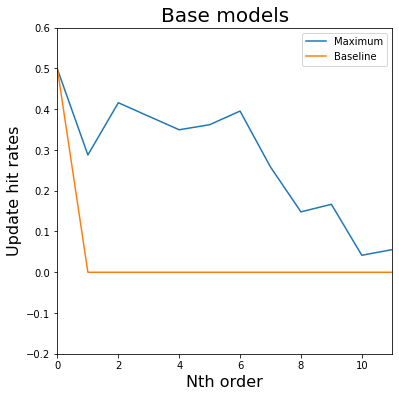

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlim(0,11)
plt.ylim(-0.2, 0.6)
plt.plot(np.nanmean(scores_update_nolimit, axis=0), label = 'Maximum')
#plt.plot(np.nanmean(scores_update_only_new, axis=0), label = 'Marginal')
plt.plot(np.nanmean(scores_update_only_old, axis=0), label = 'Baseline')

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Update hit rates', fontsize=16)
plt.title("Base models", fontsize=20)
plt.legend()
plt.show()

<ipython-input-47-93ba4b12225a>:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit_nolimit, axis=0), label = 'Maximum')
<ipython-input-47-93ba4b12225a>:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit_only_old, axis=0), label = 'Baseline')


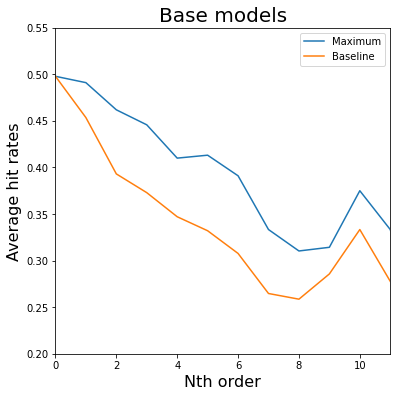

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlim(0,11)
plt.ylim(0.2, 0.55)
plt.plot(np.nanmean(scores_hit_nolimit, axis=0), label = 'Maximum')
#plt.plot(np.nanmean(scores_hit_only_new, axis=0), label = 'Marginal')
plt.plot(np.nanmean(scores_hit_only_old, axis=0), label = 'Baseline')

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Average hit rates', fontsize=16)
plt.title("Base models", fontsize=20)
plt.legend()
plt.show()

# Plotting w1, w2 

In [ ]:
# ## Fitting w1, w2 with Grid Search

# # objective function
# def eval_scores(w1, w2):
#   scores_mat_weighted = evaluate_updating(df_unseen, model, model, updating_logic_basic_weighted_modified, w1, w2)

#   return np.nanmean(scores_mat_weighted, axis=0)
 
#  # Grid Search

# scores_res2 = np.empty((1, max(df_unseen['n_orders'])))
# scores_res2[:] = np.nan

# plt.figure(figsize=(20, 6))

# i=0
# for w1 in range(0,8,2):
#   w1 *= 0.1
#   for w2 in range(0,8,2):
#     w2 *= 0.1
#     i+=1
#     print(i, " th w1: ", w1, " w2: ", w2, "score: ", np.nanmean(scores_tmp))
    
#     scores_tmp = eval_scores(w1, w2)
#     lab = ["w1: ", w1, " w2: ", w2]
#     plt.plot(sc, label = lab)#, label = 'w1: 0 w2: 0')

    
#     scores_res2 = np.concatenate((scores_res2, scores_tmp.reshape(1,-1)), axis=0)
    
#     np.save('scores', scores_res)

# plt.legend()
# plt.show()

In [ ]:
sc = np.load(path + '/scores.npy')
sc = sc[1:]
maxparam = np.argsort([np.nanmean(x[:10]) for x in sc])[-1]
print(f"Parameters show the highest average update hit rates untill 10th unique order are: w1={round((maxparam//6) * 0.1,2)}, w2={round((maxparam%6) * 0.1,2)}")

Parameters show the highest average update hit rates untill 10th unique order are: w1=0.1, w2=0.1


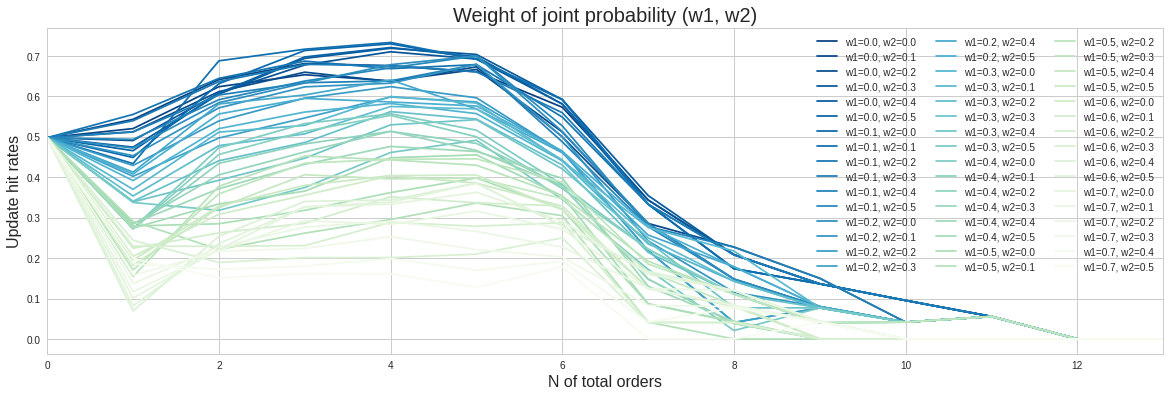

In [ ]:
sc = np.load(path + '/scores.npy')
sc = sc[1:]
plt.style.use('seaborn-notebook')

plt.figure(figsize=(20, 6))
plt.title('Weight of joint probability (w1, w2)', fontsize=20)
plt.xlim((0,13))

n=48
colors = plt.cm.GnBu(np.linspace(0,1,n))[::-1]
for i in range(n):
  plt.plot(sc[i], label =  f"w1={round((i//6) * 0.1,2)}, w2={round((i%6) * 0.1,2)}", color = colors[i])

plt.legend(ncol=3)
plt.xlabel('N of total orders', fontsize=16)
plt.ylabel('Update hit rates', fontsize=16)
plt.show()

In [ ]:
# ## Fitting w1, w2 with Grid Search

# scores_res = np.empty((1, max(df_unseen['n_orders'])))
# scores_res[:] = np.nan

# scores_res2 = np.empty((1, max(df_unseen['n_orders'])))
# scores_res2[:] = np.nan

# plt.figure(figsize=(20, 6))

# for w1 in range(0,5,1):
#   w1 *= 0.1
#   for w2 in range(0,5,1):
#     w2 *= 0.1
    
#     scores_update_w1w2, scores_hit_w1w2 = evaluate_updating(df_unseen, model, model, updating_logic_joint_prob_curr_prev, w1, w2, w3)
#     scores_res = np.concatenate((scores_res, np.nanmean(scores_update_w1w2, axis=0).reshape(1,-1)), axis=0)
#     scores_res2 = np.concatenate((scores_res2, np.nanmean(scores_hit_w1w2, axis=0).reshape(1,-1)), axis=0)
    
#     np.save(path + '/scores_update_w1w2', scores_res)
#     np.save(path + '/scores_hit_w1w2', scores_res2)


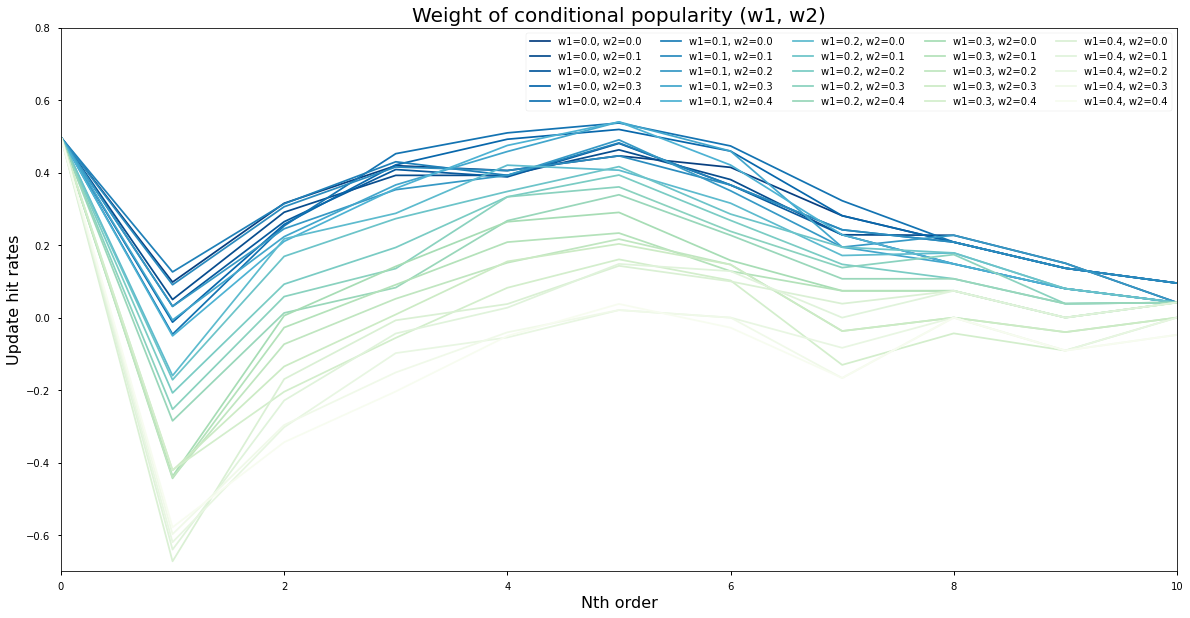

In [ ]:
sc = np.load(path + '/scores_update_w1w2.npy')
sc = sc[1:]


plt.style.use('seaborn-notebook')
plt.figure(figsize=(20, 10))

plt.title('Weight of conditional popularity (w1, w2)', fontsize=20)
plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Update hit rates', fontsize=16)
plt.xlim(0, 10)
plt.ylim(-0.7, 0.8)
n = sc.shape[0]
colors = plt.cm.GnBu(np.linspace(0,1,n))[::-1]
for i in range(n):
  plt.plot(sc[i], label =  f"w1={round((i//5) * 0.1,2)}, w2={round((i%5) * 0.1,2)}", color = colors[i])

#plt.plot(sc[3], color = "Red", linewidth=4)
plt.legend(ncol=5, fontsize=10)
plt.show()

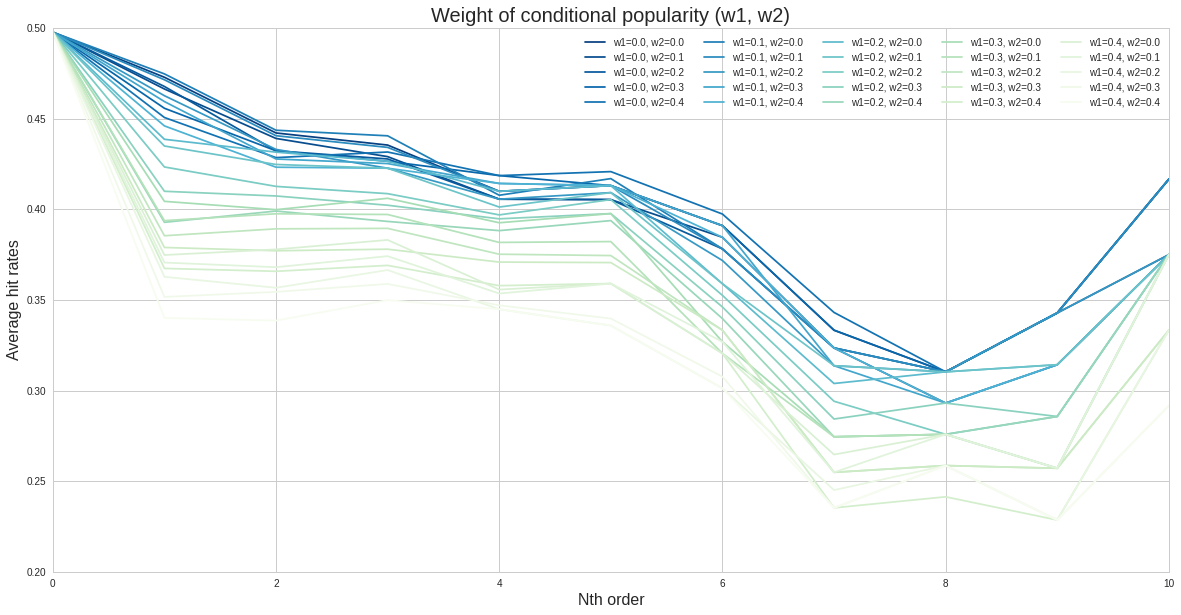

In [ ]:
sc = np.load(path + '/scores_hit_w1w2.npy')
sc = sc[1:]


plt.style.use('seaborn-notebook')
plt.figure(figsize=(20, 10))

plt.title('Weight of conditional popularity (w1, w2)', fontsize=20)
plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Average hit rates', fontsize=16)
plt.xlim(0, 10)
plt.ylim(0.2, 0.5)
n = sc.shape[0]
colors = plt.cm.GnBu(np.linspace(0,1,n))[::-1]
for i in range(n):
  plt.plot(sc[i], label =  f"w1={round((i//5) * 0.1,2)}, w2={round((i%5) * 0.1,2)}", color = colors[i])


#plt.plot(sc[3], color = "Red", linewidth=4)
plt.legend(ncol=5, fontsize=10)
plt.show()

In [ ]:
sc2 = [x[:11] for x in sc]
np.nanmean(sc2, axis=1).argsort()

array([24, 23, 22, 19, 18, 21, 20, 17, 16, 15, 14, 13, 12, 11, 10,  9,  2,
        8,  7,  1,  3,  6,  5,  4,  0])

In [ ]:
# ## Fitting w3 with Grid Search

# scores_res = np.empty((1, max(df_unseen['n_orders'])))
# scores_res[:] = np.nan

# scores_res2 = np.empty((1, max(df_unseen['n_orders'])))
# scores_res2[:] = np.nan

# w1, w2 = 0, 0.4
# for w3 in range(10):
#     w3 *= 0.1
#     print(w3)
#     scores_update_joint_prob_curr_prev, scores_hit_joint_prob_curr_prev = evaluate_updating(df_unseen, model, model, updating_logic_joint_prob_curr_prev, w1, w2, w3)
#     scores_res = np.concatenate((scores_res, np.nanmean(scores_update_joint_prob_curr_prev, axis=0).reshape(1,-1)), axis=0)
#     scores_res2 = np.concatenate((scores_res2, np.nanmean(scores_hit_joint_prob_curr_prev, axis=0).reshape(1,-1)), axis=0)
    
#     np.save(path + '/scores_update_w3', scores_res)
#     np.save(path + '/scores_hit_w3', scores_res2)
  

In [ ]:
scores_res = np.load(path + '/scores_update_w3.npy')
scores_res2 = np.load(path + '/scores_hit_w3.npy')

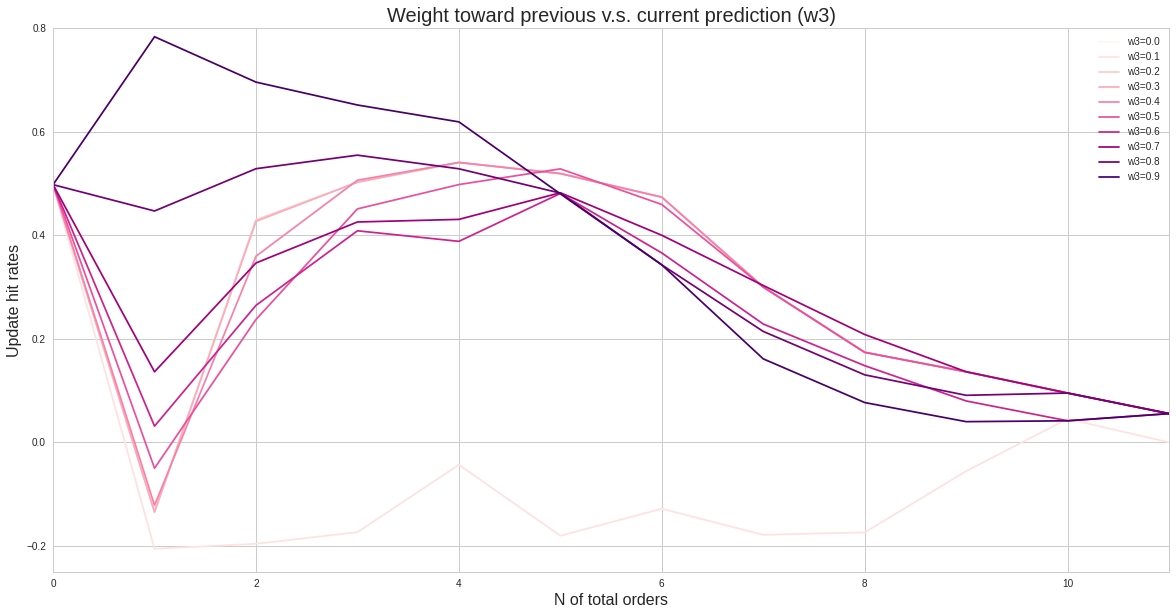

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(20, 10))
plt.xlim(0,11)
plt.ylim(-0.25, 0.8)

plt.title('Weight toward previous v.s. current prediction (w3)', fontsize=20)
plt.xlabel('N of total orders', fontsize=16)
plt.ylabel('Update hit rates', fontsize=16)

n=10
colors = plt.cm.RdPu(np.linspace(0,1,n))
for i in range(n):
  plt.plot(scores_res[i], label =  f"w3={round(i*0.1,2)}", color = colors[i])

plt.legend()
plt.show()

In [ ]:
sc2 = [x[:11] for x in scores_res2[1:]]
np.nanmean(sc2, axis=1).argsort()

array([0, 5, 8, 1, 2, 3, 4, 7, 6])

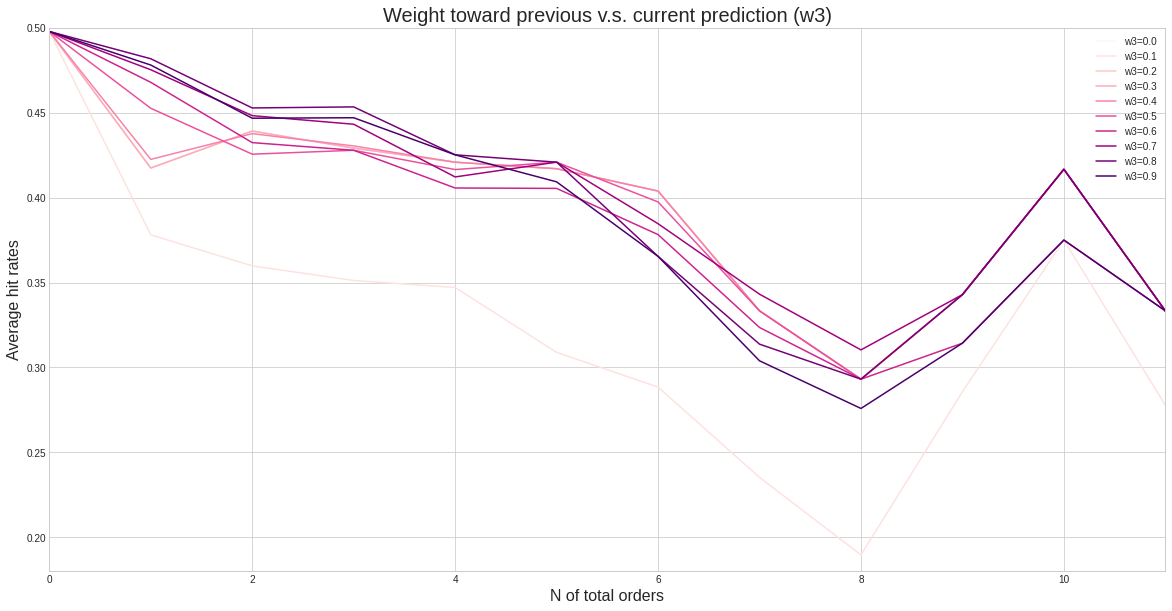

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(20, 10))
plt.xlim((0,11))
plt.ylim((0.18,0.5))

plt.title('Weight toward previous v.s. current prediction (w3)', fontsize=20)
plt.xlabel('N of total orders', fontsize=16)
plt.ylabel('Average hit rates', fontsize=16)

n=10
colors = plt.cm.RdPu(np.linspace(0,1,n))
for i in range(n):
  plt.plot(scores_res2[i], label =  f"w3={round(i*0.1,2)}", color = colors[i])


plt.legend()
plt.show()

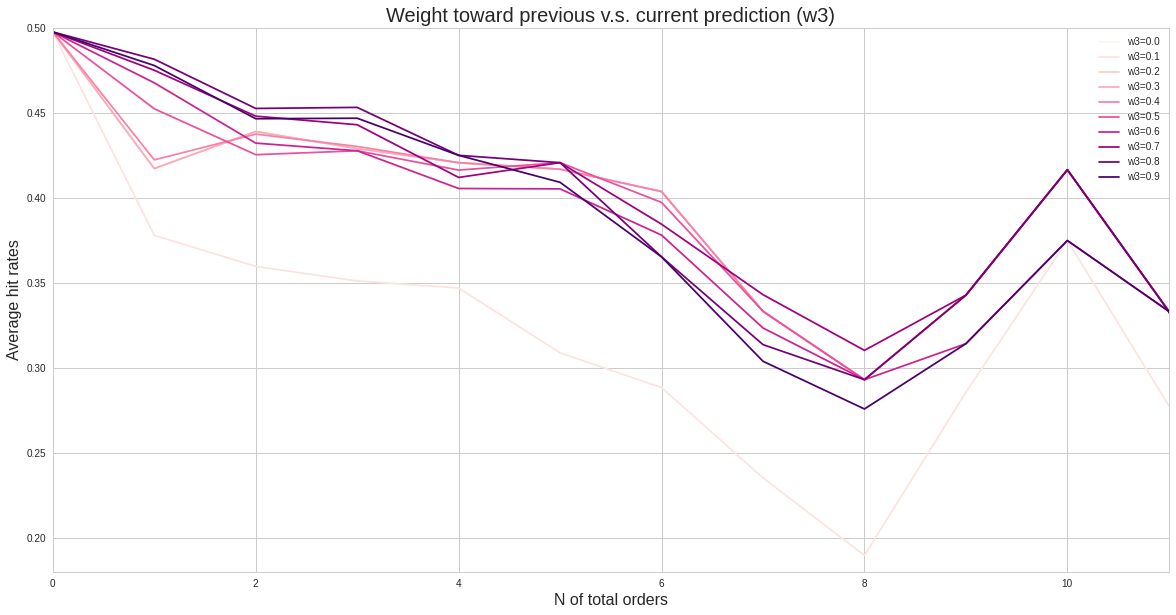

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(20, 10))
plt.xlim((0,11))
plt.ylim((0.18,0.5))

plt.title('Weight toward previous v.s. current prediction (w3)', fontsize=20)
plt.xlabel('N of total orders', fontsize=16)
plt.ylabel('Average hit rates', fontsize=16)

n=10
colors = plt.cm.RdPu(np.linspace(0,1,n))
for i in range(n):
  plt.plot(scores_res2[i], label =  f"w3={round(i*0.1,2)}", color = colors[i])


plt.legend()
plt.show()

Model with the fitted parameters

# Analysis on the characteristics of the engine's recomendation

In [ ]:
def popular_items_hit_rates(trained_, y_, recommed_):

    popularity = zscore(trained_.iloc[:,11:].mean(axis=0))
    popularity = popularity > np.median(popularity)
    popular_item = np.where(popularity == True)
    un_popular_item = np.where(popularity == False)

    recom_pop, y_pop = recommed_[0][popular_item], y_.numpy()[0][popular_item]
    hit_pop = y_pop * recom_pop

    recom_unpop, y_unpop = recommed_[0][un_popular_item], y_.numpy()[0][un_popular_item]
    hit_unpop = y_unpop * recom_unpop

    return hit_pop, hit_unpop

In [ ]:
# Updating

def final_evaluation(validation_data, first_model, updating_model, updating_fn, w1, w2, w3):

    validation_data['n_orders'] = validation_data['items'].apply(lambda x: len(str(x).split(',')))

    scores_mat = np.empty((1, max(validation_data['n_orders'])))
    scores_mat[:] = np.nan
    scores_mat2 = np.empty((1, max(validation_data['n_orders'])))
    scores_mat2[:] = np.nan
    scores_mat3 = np.empty((1, max(validation_data['n_orders'])))
    scores_mat3[:] = np.nan
    scores_mat4 = np.empty((1, max(validation_data['n_orders'])))
    scores_mat4[:] = np.nan
    scores_mat5 = np.empty((1, max(validation_data['n_orders'])))
    scores_mat5[:] = np.nan

    ''' Item batchs with each length of the orders
    '''
    for n in tqdm(set(validation_data['n_orders'])):

        tmp = validation_data[validation_data['n_orders'] == n]
        tmp['first_item'] = tmp['items'].apply(lambda x: x[0]) 
        tmp = tmp.reset_index().drop('index', axis=1) 
        score_tmp = [[np.NaN] * tmp.shape[0]] * max(validation_data['n_orders']) #empty matrix size of datapoints * 28(max unique items)
        score_tmp2 = [[np.NaN] * tmp.shape[0]] * max(validation_data['n_orders']) 
        score_tmp5 = [[np.NaN] * tmp.shape[0]] * max(validation_data['n_orders']) 

        popularity = zscore(X.iloc[:,11:].mean(axis=0))
        popularity = popularity > np.median(popularity)
        popular_item = np.where(popularity == True)
        un_popular_item = np.where(popularity == False)

        score_tmp3 = [[np.NaN] * len(list(popular_item)[0])] * max(validation_data['n_orders']) 
        score_tmp4 = [[np.NaN] * len(list(un_popular_item)[0])] * max(validation_data['n_orders']) 

        f_items = item_encoder.transform([i] for i in tmp['first_item'])
        temp_item = f_items
        rest_items = item_encoder.transform(i for i in tmp['items'])
        rest_items -= temp_item # Get rid of the first item
        recommed_items = np.zeros_like(f_items)
        recommed_history = {}

        for i in range(n-1):
            tmp['next_item'] = tmp['items'].apply(lambda x: x[i])

            temp_item = item_encoder.transform([i] for i in tmp['next_item'])

            ''' In case an item overlaps with previously bought one
              elements of f_items become > 1 / elements of r_items become < 0
              the code below gets rid of the overlapping products and convert the item lists into integer
            '''

            f_items, rest_items = f_items + temp_item, rest_items - temp_item
            f_items, rest_items = 1*(f_items > 0), 1*(rest_items > 0)

            df_current = tmp.drop(['items', 'n_orders', 'first_item', 'next_item'], axis=1)

            item_cols = ['item_' + i for i in item_encoder.classes_]
            new_df_current = pd.DataFrame(f_items, columns = item_cols)

            X_temp = pd.concat([df_current, new_df_current], axis=1)
            y_temp = rest_items

            X_temp_tensor = tf.convert_to_tensor(X_temp, dtype = tf.float32)
            y_temp_tensor = tf.convert_to_tensor(y_temp, dtype = tf.int64) 


            if i == 0:
                prev_y_pred = first_model.predict(X_temp_tensor, batch_size = len(X_temp_tensor), verbose=0)
                top3_recommendation = post_processing_logic(X_train=X, w=0, y_hat=prev_y_pred) # from y_pred to binary vector
                recommed_items += top3_recommendation.astype(int) # Add the recommendation into history
                score_hit = hit_rates_vector(y_temp_tensor, top3_recommendation)
                score_update = score_hit
                hit_pop, hit_unpop = popular_items_hit_rates(X, y_temp_tensor, top3_recommendation)
                score_accumulated = hit_rates_vector(y_temp_tensor, recommed_items)

            else:
                updated_y_pred = updating_model.predict(X_temp_tensor, verbose=0)
                modified_top3_recommendation = updating_fn(X, updated_y_pred, prev_y_pred, f_items, recommed_items, w1, w2, w3)
                recommed_items += modified_top3_recommendation.astype(int)
                recommed_items = recommed_items > 0 # Record the unique item of recommendation
                recommed_items = recommed_items.astype(int)
                prev_y_pred = updated_y_pred
                score_update = updated_hit_rates(y_temp_tensor, modified_top3_recommendation, top3_recommendation) 
                score_hit = hit_rates_vector(y_temp_tensor, modified_top3_recommendation)
                hit_pop, hit_unpop = popular_items_hit_rates(X, y_temp_tensor, modified_top3_recommendation)
                score_accumulated = hit_rates_vector(y_temp_tensor, recommed_items)

            score_tmp[i] = list(score_update)
            score_tmp2[i] = list(score_hit)
            score_tmp3[i] = list(hit_pop)
            score_tmp4[i] = list(hit_unpop)
            score_tmp5[i] = list(score_accumulated)

        scores_mat = np.concatenate((scores_mat, np.transpose(score_tmp)), axis=0)
        scores_mat2 = np.concatenate((scores_mat2, np.transpose(score_tmp2)), axis=0)
        scores_mat3 = np.concatenate((scores_mat3, np.transpose(score_tmp3)), axis=0)
        scores_mat4 = np.concatenate((scores_mat4, np.transpose(score_tmp4)), axis=0)
        scores_mat5 = np.concatenate((scores_mat5, np.transpose(score_tmp5)), axis=0)
        # For single order: NaN mat is concatenated
  
    return scores_mat, scores_mat2, scores_mat3, scores_mat4, scores_mat5

In [ ]:
X_notsingle = X_unseen[(y_unseen.sum(axis=1) > 0)]
y_notsingle = y_unseen[(y_unseen.sum(axis=1) > 0)]
X_val_unseen_tensor = tf.convert_to_tensor(X_notsingle, dtype = tf.float32)
y_val_unseen_tensor = tf.convert_to_tensor(y_notsingle, dtype=tf.int64) 

print("Evaluate on test data with more than one order")
results = model.evaluate(X_val_unseen_tensor, y_val_unseen_tensor, batch_size=128)
print(" ".join("{}: {}".format(x, round(y,3)) for x, y in zip(model.metrics_names, results)))

Evaluate on test data with more than one order
24/24 [==============================] - 1s 25ms/step - loss: 0.0666 - precision: 0.5000 - recall: 0.0136 - hit_rates: 0.5292
loss: 0.067 precision: 0.5 recall: 0.014 hit_rates: 0.529


In [ ]:
w1, w2, w3 = 0, 0.3, 0.5
scores_update_nolimit, scores_hit_nolimit, scores_pop_nolimit, scores_unpop_nolimit, scores_accumulated_nolimit = final_evaluation(df_unseen, model, model, updating_logic_nolimit, w1, w2, w3)
scores_update_only_old, scores_hit_only_old, scores_pop_only_old, scores_unpop_only_old, scores_accumulated_only_old = final_evaluation(df_unseen, model, model, updating_logic_only_old, w1, w2, w3)
scores_update, scores_hit, scores_pop, scores_unpop, scores_accumulated = final_evaluation(df_unseen, model, model, updating_logic_joint_prob_curr_prev, w1, w2, w3)

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-55-876578134dba>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['first_item'] = tmp['items'].apply(lambda x: x[0])
 10%|▉         | 2/21 [00:00<00:06,  2.82it/s]<ipython-input-39-257292fcd160>:23: RuntimeWarning: invalid value encountered in true_divide
  updated_hit_vec = (np.sum(updated_correct, axis=1) - np.sum(updated_wrong, axis=1)) / (np.sum(updated_correct, axis=1) + np.sum(updated_wrong, axis=1))
100%|██████████| 21/21 [06:32<00:00, 18.70s/it]


<ipython-input-66-94181a0fb3b2>:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_accumulated_nolimit, axis=0), label = 'Maximum')
<ipython-input-66-94181a0fb3b2>:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_accumulated_only_old, axis=0), label = 'Baseline')
<ipython-input-66-94181a0fb3b2>:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_accumulated, axis=0), label = 'Update Model')


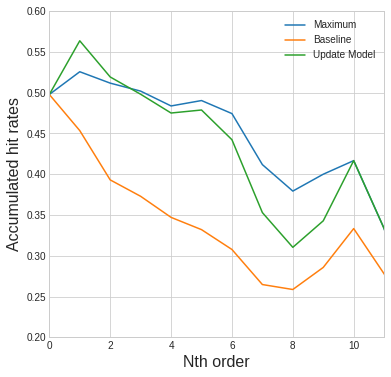

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlim(0,11)
plt.ylim(0.2, 0.6)
plt.plot(np.nanmean(scores_accumulated_nolimit, axis=0), label = 'Maximum')
plt.plot(np.nanmean(scores_accumulated_only_old, axis=0), label = 'Baseline')
plt.plot(np.nanmean(scores_accumulated, axis=0), label = 'Update Model')

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Accumulated hit rates', fontsize=16)
plt.title("", fontsize=20)
plt.legend()
plt.show()

<ipython-input-67-94181a0fb3b2>:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_accumulated_nolimit, axis=0), label = 'Maximum')
<ipython-input-67-94181a0fb3b2>:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_accumulated_only_old, axis=0), label = 'Baseline')
<ipython-input-67-94181a0fb3b2>:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_accumulated, axis=0), label = 'Update Model')


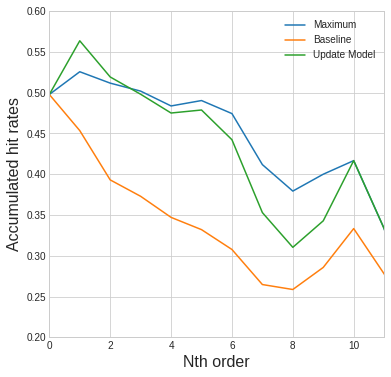

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlim(0,11)
plt.ylim(0.2, 0.6)
plt.plot(np.nanmean(scores_accumulated_nolimit, axis=0), label = 'Maximum')
plt.plot(np.nanmean(scores_accumulated_only_old, axis=0), label = 'Baseline')
plt.plot(np.nanmean(scores_accumulated, axis=0), label = 'Update Model')

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Accumulated hit rates', fontsize=16)
plt.title("", fontsize=20)
plt.legend()
plt.show()

<ipython-input-79-6ca896306281>:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_update_nolimit, axis=0), label = 'Maximum')
<ipython-input-79-6ca896306281>:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_update_only_old, axis=0), label = 'Baseline')
<ipython-input-79-6ca896306281>:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_update, axis=0), label = 'Update Model')


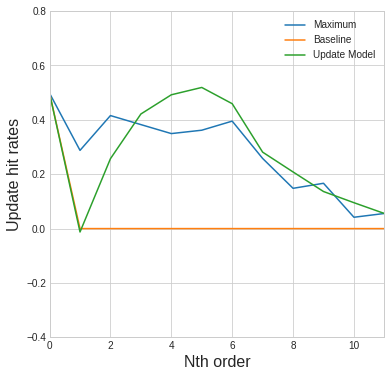

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlim(0,11)
plt.ylim(-0.4, 0.8)
plt.plot(np.nanmean(scores_update_nolimit, axis=0), label = 'Maximum')
plt.plot(np.nanmean(scores_update_only_old, axis=0), label = 'Baseline')
plt.plot(np.nanmean(scores_update, axis=0), label = 'Update Model')

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Update hit rates', fontsize=16)
plt.title("", fontsize=20)
plt.legend()
plt.show()

<ipython-input-81-b2968d9a7c7d>:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit_nolimit, axis=0), label = 'Maximum')
<ipython-input-81-b2968d9a7c7d>:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit_only_old, axis=0), label = 'Baseline')
<ipython-input-81-b2968d9a7c7d>:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit, axis=0), label = 'Update Model')


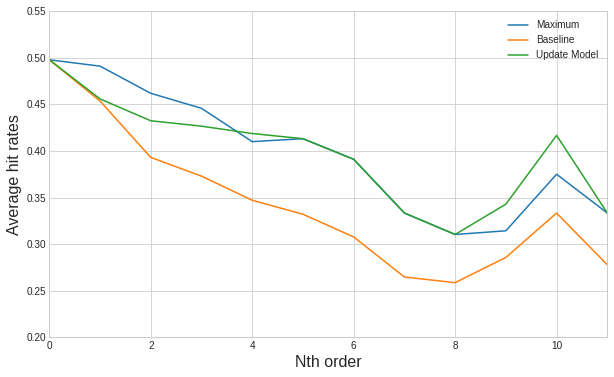

In [ ]:
plt.figure(figsize=(10, 6))
plt.xlim(0,11)
plt.ylim(0.2, 0.55)
plt.plot(np.nanmean(scores_hit_nolimit, axis=0), label = 'Maximum')
plt.plot(np.nanmean(scores_hit_only_old, axis=0), label = 'Baseline')
plt.plot(np.nanmean(scores_hit, axis=0), label = 'Update Model')

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Average hit rates', fontsize=16)
plt.title("", fontsize=20)
plt.legend()
plt.show()

In [ ]:
popularity = zscore(X.iloc[:,11:].mean(axis=0))
X_unseen_popular = X_unseen.iloc[:,11:] * popularity
order_popular = X_unseen_popular.mean(axis=1) > np.quantile(X_unseen_popular.mean(axis=1), 0.5)
order_unpopular = X_unseen_popular.mean(axis=1) < np.quantile(X_unseen_popular.mean(axis=1), 0.5)

<ipython-input-83-6ee4dc386383>:12: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit[1:][order_popular], axis=0), label = 'Update Model_Pop', color = colors[3])
<ipython-input-83-6ee4dc386383>:13: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(scores_hit[1:][order_unpopular], axis=0), label = 'Update Model_UnPop', color = colors[7])


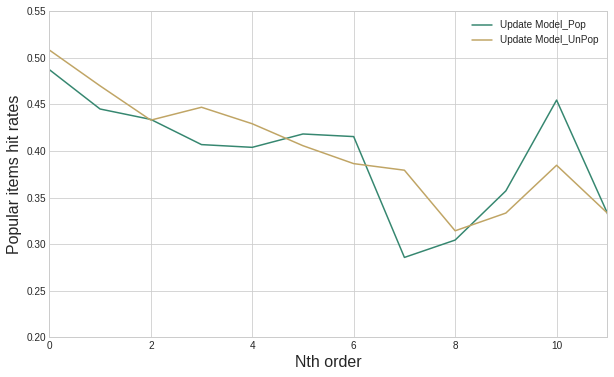

In [ ]:
plt.figure(figsize=(10, 6))

plt.xlim(0,11)
plt.ylim(0.2,0.55)

colors = plt.cm.gist_earth(np.linspace(0,1,10))

#plt.plot(np.nanmean(scores_hit_nolimit[1:][order_popular], axis=0), label = 'Maximum_Pop', color = colors[0])
#plt.plot(np.nanmean(scores_hit_nolimit[1:][order_unpopular], axis=0), label = 'Maximum_Unpop', color = colors[2])
#plt.plot(np.nanmean(scores_hit_only_old[1:][order_popular], axis=0), label = 'Baseline_Pop', color = colors[4])
#plt.plot(np.nanmean(scores_hit_only_old[1:][order_unpopular], axis=0), label = 'Baseline_Unpop', color = colors[5])
plt.plot(np.nanmean(scores_hit[1:][order_popular], axis=0), label = 'Update Model_Pop', color = colors[3])
plt.plot(np.nanmean(scores_hit[1:][order_unpopular], axis=0), label = 'Update Model_UnPop', color = colors[7])

plt.xlabel('Nth order', fontsize=16)
plt.ylabel('Popular items hit rates', fontsize=16)
plt.title("", fontsize=20)
plt.legend()
plt.show()